# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Brood-Size-Analysis,-Fig-4" data-toc-modified-id="Brood-Size-Analysis,-Fig-4-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Brood Size Analysis, Fig 4</a></div><div class="lev1 toc-item"><a href="#Lawn-Leaving-Screen" data-toc-modified-id="Lawn-Leaving-Screen-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Lawn Leaving Screen</a></div><div class="lev2 toc-item"><a href="#Fig-6b,-Inset" data-toc-modified-id="Fig-6b,-Inset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fig 6b, Inset</a></div><div class="lev2 toc-item"><a href="#Fig-6a,b" data-toc-modified-id="Fig-6a,b-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Fig 6a,b</a></div><div class="lev1 toc-item"><a href="#Ovulation-Screen,-Fig.-5" data-toc-modified-id="Ovulation-Screen,-Fig.-5-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ovulation Screen, Fig. 5</a></div>

Important note: If any of the figures don't compile on the first try, try them again. Sometimes LaTex causes issues with plotting.

In [1]:
import collections
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numba to make things faster
import numba

# The MCMC Hammer
import emcee

# Numerical differentiation package
import numdifftools as ndt

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

import matplotlib.patheffects as path_effects

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}


# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('dark', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import datetime as dt

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


In [2]:
xticksize = 15
yticksize = 15
xlabelsize = 25
ylabelsize = 25
titlesize = 25

In [3]:
input_path = '../input/rnai_screen_results/'
output_path = '../output/rnai_screen_results/'
graph_path = '../output/raw_brood_assay_plots/'

df = pd.read_csv(input_path + 'brood_assay_screen.csv', sep=',')
names = pd.read_csv(input_path + 'rnai_genes_dict.csv')

df.strain = df.strain.apply(str)
df.strain = df.strain.apply(str.lower)

names.code = names.code.apply(str)
names.code = names.code.apply(str.lower)

seq_verify = pd.read_csv(input_path + 'sequence_verification.csv')

df.dropna(subset=['brood_size'], inplace=True)

In [4]:
grouped = pd.groupby(df, by=['strain', 'assay_date', 'worm_measured'])

i = 0
for name, group in grouped:
    days_counted = np.array([len(group.brood_size)])
    g = np.array([group.brood_size.sum()])
    tb = np.concatenate([name, g, days_counted])
    if i == 0:
        total_brood = tb
        i += 1
    else:
        total_brood = np.vstack([total_brood, tb])

In [5]:
df2 = pd.DataFrame(total_brood, columns=['strain', 'date', 'worm', 'total_brood_size', 'days_counted'])
df2[['total_brood_size']] = df2[['total_brood_size']].astype(np.float)
df2[['days_counted']] = df2[['days_counted']].astype(np.int)

In [6]:
def translate(x):
    """A function to go between rnai code and gene (human-readable) name."""
    if len(names[names.code == x].gene_name.values):
        return names[names.code == x].gene_name.values[0]
    else:
        return 'badcode'
    
def nice_plotting_with_shade(df, x_name, y_name, control='gfp', alpha=0.05,
                             verbose=False, test='ttest',**kwargs):
    """
    """    
    if test not in ['ttest', 'rank']:
        raise ValueError('test must be one of `ttest` or `rank`')
        
    hue = kwargs.pop('hue', 'date')
    ylim = kwargs.pop('ylim', [])
    bbox_to_anchor = kwargs.pop('bbox_to_anchor', (1.15, 1))
    rotation = kwargs.pop('rotation', 90)
    
    fig, ax = plt.subplots()
    g = sns.swarmplot(x_name, y_name, hue=hue, data=df, size=10, ax=ax)
    plt.legend(bbox_to_anchor=bbox_to_anchor)
    plt.xticks(rotation=rotation)
    
    if len(ylim) > 0:
        plt.ylim(ylim)
    else:
        plt.ylim((0, 100))
    
    # shading and testing:
    
    control_data = df[(df[x_name] == control)][y_name]
    sig_genes = []
    for i, gene in enumerate(df[x_name].unique()):
        # if gene is control, shade it in and continue
        # with the next loop
        if gene == control:
            ax.fill_between([i-0.5, i+0.5], 0.0, ax.get_ylim()[1], 
                            where=[1,1], color='#2ca25f', alpha=0.4, zorder=0)    
            continue
        
        # otherwise, test it and shade it in if pval < alpha
        x = df[df[x_name] == gene][y_name]
        
        if test == 'ttest':
            pval = st.ttest_ind(control_data, x, equal_var=False)[1]
        else:
            pval = st.mannwhitneyu(control_data, x)[1]
            
        if pval > alpha:
            continue
        
        if verbose:
            print('{0}, pvalue: {1:.2g}'.format(gene, pval))
        ax.fill_between([i-0.5, i+0.5], 0.0, ax.get_ylim()[1], 
                    where=[1,1], color='#404040', alpha=0.6, zorder=0)
        sig_genes += [gene]
    return sig_genes

def fix_labels(xlabel='', ylabel='', title='', xticksize=xticksize, yticksize=yticksize,
              ylabelsize=ylabelsize, xlabelsize=xlabelsize, titlesize=titlesize, effects=True,
              **kwargs):
    
    xrotation = kwargs.pop('xrotation', 0)
    yrotation = kwargs.pop('yrotation', 0)
    ytitle = kwargs.pop('ytitle', 1)
    
    if effects == False:
        plt.title(title, y=ytitle, fontsize=titlesize)
        plt.xticks(rotation=xrotation, fontsize=xticksize)
        plt.yticks(rotation=yrotation, fontsize=yticksize)
        plt.xlabel(xlabel, fontsize=xlabelsize)
        plt.ylabel(ylabel, fontsize=ylabelsize)
    else:
        
        plt.title(title, y=ytitle, fontsize=titlesize).set_path_effects([path_effects.Normal()])
        plt.xlabel(xlabel, fontsize=xlabelsize).set_path_effects([path_effects.Normal()])
        plt.ylabel(ylabel, fontsize=ylabelsize).set_path_effects([path_effects.Normal()])
        plt.xticks(rotation=xrotation, fontsize=xticksize)
        plt.yticks(rotation=yrotation, fontsize=yticksize)
        
        ax = plt.gca()
        for i, label in enumerate(ax.get_xticklabels()):
            ax.get_xticklabels()[i].set_path_effects([path_effects.Normal()])
        for i, label in enumerate(ax.get_yticklabels()):
            ax.get_yticklabels()[i].set_path_effects([path_effects.Normal()])
    
        

# Brood Size Analysis, Fig 4




no grouping
No FDR or Bonferroni adjustment
pvalue threshold for this test is set to: 0.05

    Under a normal model, at this alpha, you should expect 1.15 false positives on average
    
exc-5, pvalue: 0.017
R09H10.5, pvalue: 9.6e-05
ard-1, pvalue: 0.0039
ape-1, pvalue: 0.0052
W07G4.5, pvalue: 0.01
R07E4.1, pvalue: 0.0055
zip-3 , pvalue: 4.4e-05


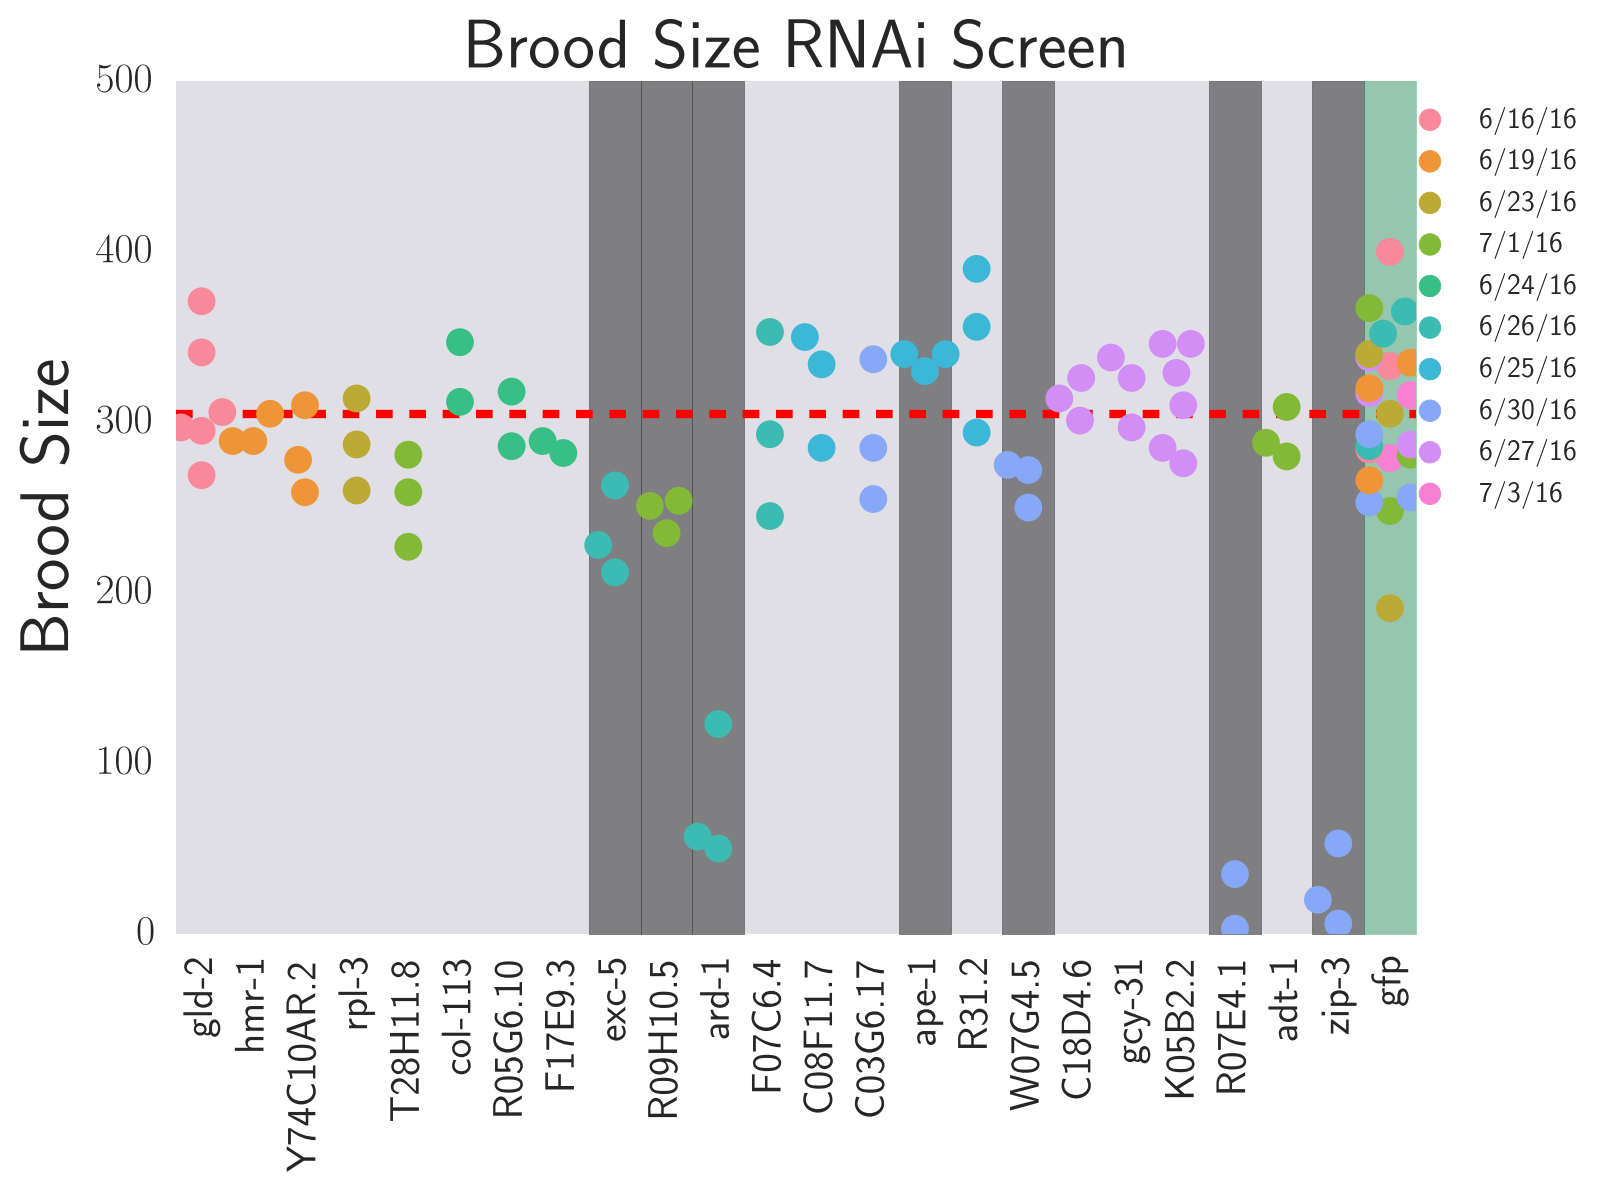

In [7]:
df2['gene'] = df2.strain.apply(translate)

temp = df2[df2.days_counted>2].copy()

# drop any and all codes that did NOT pass sequence_verification
# only sequences that were verified were sequences that passed 
# statistical testing in the first place.

df_to_use = temp[~temp.strain.isin(seq_verify[seq_verify.right_sequence == 0].code)].copy()


# stat_test_group = df_to_use.groupby(['gene', 'date'])

# Since I can't see any effect of date on brood size, take all the gfp
# results we got and use them to test for significance
alpha = 0.05
print('\n\n\nno grouping')
print('No FDR or Bonferroni adjustment')
print('pvalue threshold for this test is set to: {0}'.format(alpha))
if (len(df_to_use)-1)*alpha > 5:
    print("""
You ought to consider adding FDR corrections, 
because you have tested enough strains that you
should expect {0:.2f} false positives from this screen
on average
""".format( (len(df_to_use.gene.unique())-1)*alpha ))
else:
    print("""
    Under a normal model, at this alpha, you should expect {0:.2f} false positives on average
    """.format((len(df_to_use.gene.unique())-1)*alpha))

sig_genes = nice_plotting_with_shade(df_to_use, 'gene', 'total_brood_size', ylim=(0, 500), verbose=True)

plt.axhline(df_to_use[df_to_use.gene == 'gfp'].total_brood_size.mean(), ls='--', lw=3, color='red')
# plt.title('Brood Size RNAi Screen', fontsize=titlesize)
# plt.xticks(fontsize=xticksize)
# plt.yticks(fontsize=yticksize)
# plt.xlabel('Gene', fontsize=xlabelsize).set_path_effects([path_effects.Normal()])
# plt.ylabel('Brood Size', fontsize=ylabelsize).set_path_effects([path_effects.Normal()])
fix_labels('', 'Brood Size', 'Brood Size RNAi Screen', effects=True)
plt.xticks(rotation=90)

plt.savefig(graph_path+'rnai_brood_assay_results.pdf', bbox_inches='tight')

In [8]:
def bootstrap_repeated_measurements(x, stat_fun, args=(), n_trials=1000):
    """
    Get bootstrap samples of a statistic from repeated
    measurements `x`.  `stat_fun` must be of the form
    stat_fun(x, *args).
    """
    # Indices that we use for resampling
    inds_to_choose = np.arange(len(x), dtype=int)   
    
    # Samples to save
    samples = np.empty(n_trials)
    
    return np.array(
        [stat_fun(x[np.random.choice(inds_to_choose, len(x), replace=True)])
                   for _ in range(n_trials)])

In [9]:
def gaussian_draw(mu, sigma, stat_fun, n, n_trials=10000, args=()):
    """
    Make draws from Gaussian distribution with mean mu and 
    standard deviation sigma and compute and tabulate a
    statistic using `stat_fun`.  `stat_fun` must have the form
    stat_fun(x, *args), where `x` is a NumPy array of draws.
    """
    return np.array([
            stat_fun(np.random.normal(loc=mu, scale=sigma, size=n), *args) 
            for _ in range(n_trials)])

# "Repeat" experiments
wt = df_to_use[df_to_use.gene == 'gfp'].total_brood_size
mu_wt = df_to_use[df_to_use.gene == 'gfp'].total_brood_size.mean()
var_wt = df_to_use[df_to_use.gene == 'gfp'].total_brood_size.var()

mut = df_to_use[df_to_use.gene == 'ape-1'].total_brood_size
mu_mut = df_to_use[df_to_use.gene == 'ape-1'].total_brood_size.mean()
var_mut = df_to_use[df_to_use.gene == 'ape-1'].total_brood_size.var()


samples_wt = gaussian_draw(mu_wt, np.sqrt(var_wt), np.mean, len(wt), 
                        n_trials=100000)
samples_mut = gaussian_draw(mu_mut, np.sqrt(var_mut), np.mean, len(wt), 
                        n_trials=100000)

# Compute differences in the mean
diff_samples = samples_wt - samples_mut


In [10]:
def bootstrap_repeated_measurements(x, stat_fun, args=(), n_trials=1000):
    """
    Get bootstrap samples of a statistic from repeated
    measurements `x`.  `stat_fun` must be of the form
    stat_fun(x, *args).
    """
    # Indices that we use for resampling
    inds_to_choose = np.arange(len(x), dtype=int)   
    
    # Samples to save
    samples = np.empty(n_trials)
    
    return np.array(
        [stat_fun(x[np.random.choice(inds_to_choose, len(x), replace=True)])
                   for _ in range(n_trials)])

In [11]:
def cohen_d(x, y, return_abs=False):
    """
    Cohen's d
    """
    diff = y.mean() - x.mean()
    pooled_variance = (len(x) * x.var() + len(y) * y.var()) / (len(x) + len(y))

    if return_abs:
        return np.abs(diff) / np.sqrt(pooled_variance)
    return diff / np.sqrt(pooled_variance)

In [12]:
def new_data(mu, var, n):
    """
    Generate n new data points drawing from a 
    gaussian with mean mu, variance var
    and that is truncated at 0
    """
    return np.maximum(np.random.normal(mu, np.sqrt(var), n), 0)

In [13]:
def bootstrapped_pvals(gene, reps=1000, df=df_to_use, control_name='gfp', data='total_brood_size', **kwargs):
    
    ax = kwargs.pop('ax', None)
    a = kwargs.pop('alpha', 1)
    
    if not ax:
        # Set up figure
        fig, ax = plt.subplots()

    wt = df[df.gene == control_name][data]
    mu_wt = wt.mean()
    var_wt = wt.var()
    
    mut = df[df.gene == gene][data]
    mu_mut = mut.mean()
    var_mut = mut.var()

    
    n_wt = len(wt)
    n_mut = len(mut)
    # Initialize arrays
    welch_p_values = np.empty(reps)
    cohend = np.empty(reps)
    
    # Do calcs!
    for i in range(reps):
        # Generate new data
        new_wt = new_data(mu_wt, var_wt, n_wt)
        new_mut = new_data(mu_mut, var_mut, n_mut)

        # Compute Welch's p-value
        welch_p_values[i] = st.ttest_ind(new_wt, new_mut, equal_var=False)[1] / 2
        cohend[i] = cohen_d(new_wt, new_mut)
        
    if np.mean(welch_p_values) < 0.01:
        return cohend, welch_p_values
        
    elif np.mean(welch_p_values) < 0.05:
        ax = sns.kdeplot(np.log10(welch_p_values), kernel='gau', bw='Scott', 
                        ax=ax, label='{0}'.format(gene), ls='-', lw=4, alpha=a)
    
    else:
        print(gene, 'has a mean bootstrapped pvalue of ', np.mean(welch_p_values))
        ax = sns.kdeplot(np.log10(welch_p_values), kernel='gau', bw='Scott', 
                        ax=ax, label='{0}'.format(gene), ls='-.', lw=4, alpha=a)


    ax.set_xlabel(r'$\log_{10}\,p$ (Welch)')
    ax.set_ylabel('probability')
    ax.legend(loc='upper left')
    plt.tight_layout()
    
    return cohend, welch_p_values


def bootstrapped_chisquare(gene, df, y1, y2, reps=1000, control_name='gfp', **kwargs):
        
    def p_exp(y1, y2):
        """Returns the expected probability of y1"""
        return y1/(y1+y2)
    
    wt_y1 = df[df.gene == control_name][y1]
    wt_y2 = df[df.gene == control_name][y2]
    wt_p = p_exp(wt_y1, wt_y2)
    mu_p = wt_p.mean()
    
    mut_y1 = df[df.gene == gene][y1]
    mut_y2 = df[df.gene == gene][y2]
    mut_p = p_exp(mut_y1, mut_y2)
    
    
    def choose(x1, x2, inds_to_choose):
        """Resample x1, and x2."""
        selected = np.random.choice(inds_to_choose, len(x1), replace=True)
        return x1.values[selected], x2.values[selected]

    def resampled_chisquare(x1, x2, exp, n_trials=reps):
        """
        Get bootstrap samples of a statistic from repeated
        measurements `x`.  `stat_fun` must be of the form
        stat_fun(x, *args).
        """
        if len(x1) != len(x2):
            raise ValueError('lengths of x1 and x2 must match')
            
        # Indices that we use for resampling
        inds_to_choose = np.arange(len(x1), dtype=int)   
    
        # Samples to save
        samples = np.empty(n_trials)
                
        CHI = []
        for _ in range(n_trials):
            x1_, x2_ = choose(x1, x2, inds_to_choose)
            if len(x1_) != len(x2_):
                raise ValueError('x1_ and x2_ are not the same size!')
            chi = st.chisquare(x1_, (x1_+x2_)*exp)
            CHI += [chi[1]]
            
        return CHI
    
    
    n_wt = len(wt)
    n_mut = len(mut)
    # Initialize arrays
    chi_p_values = []

    # Do calcs!
    for i in range(reps):
        # Generate new data
        inds_to_choose = np.arange(len(wt_y1), dtype=int)
        new_wt1, new_wt2 = choose(wt_y1, wt_y2, inds_to_choose)
        exp = p_exp(new_wt1, new_wt2).mean()
        
        if len(mut_y1) == len(mut_y2):
            chi_p_values += resampled_chisquare(mut_y1, mut_y2, exp)
    return chi_p_values


/Users/dangeles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


Cohen d: -1.67+/- 0.50
Cohen d: -1.39+/- 0.35
Cohen d: -5.27+/- 0.99


/Users/dangeles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


Cohen d: 0.76+/- 0.28
Cohen d: -0.94+/- 0.34
Cohen d: -6.64+/- 1.13
Cohen d: -6.56+/- 1.10


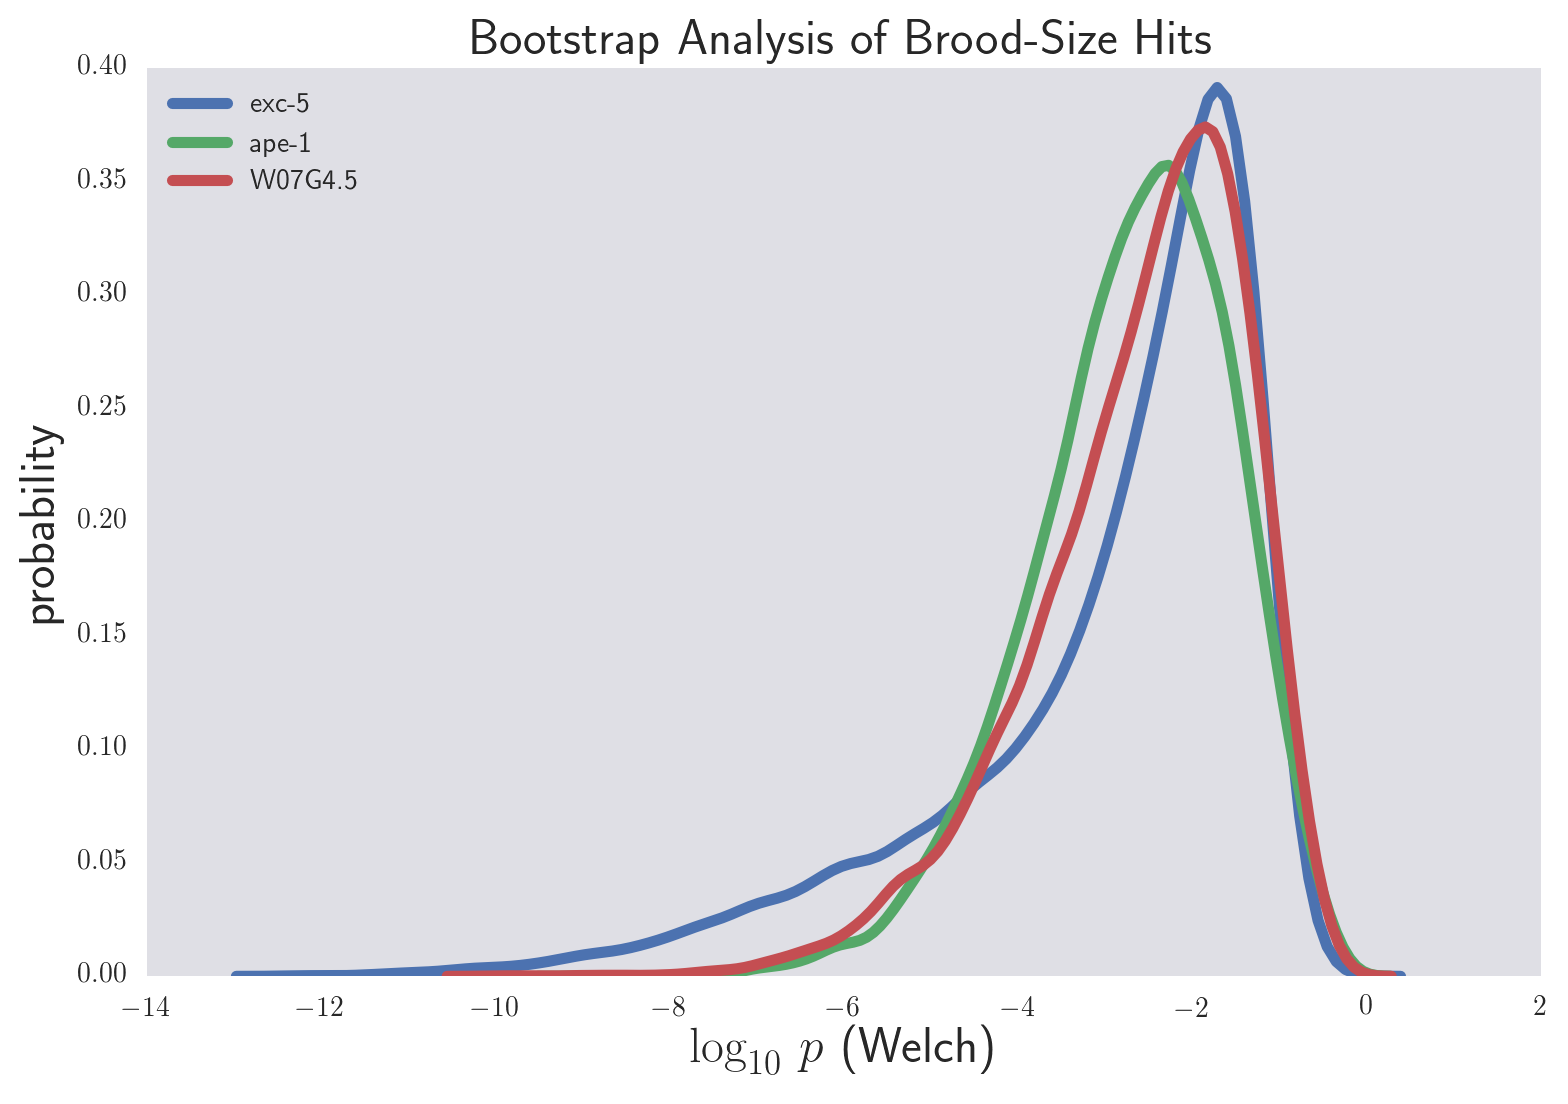

In [14]:
fig, ax = plt.subplots()
genelist = []
cd = np.array([])
reps = 10**4
cd = {}
for gene in sig_genes:
    c, w = bootstrapped_pvals(gene, reps=reps, ax=ax)
    if len(cd) == 0:
        cd = c
    else:
        cd = np.concatenate([cd, c])
    genelist = np.concatenate([genelist, [gene]*len(c)])
    print('Cohen d: {0:.2f}+/- {1:.2f}'.format(c.mean(), c.std()))
plt.title('Bootstrap Analysis of Brood-Size Hits')


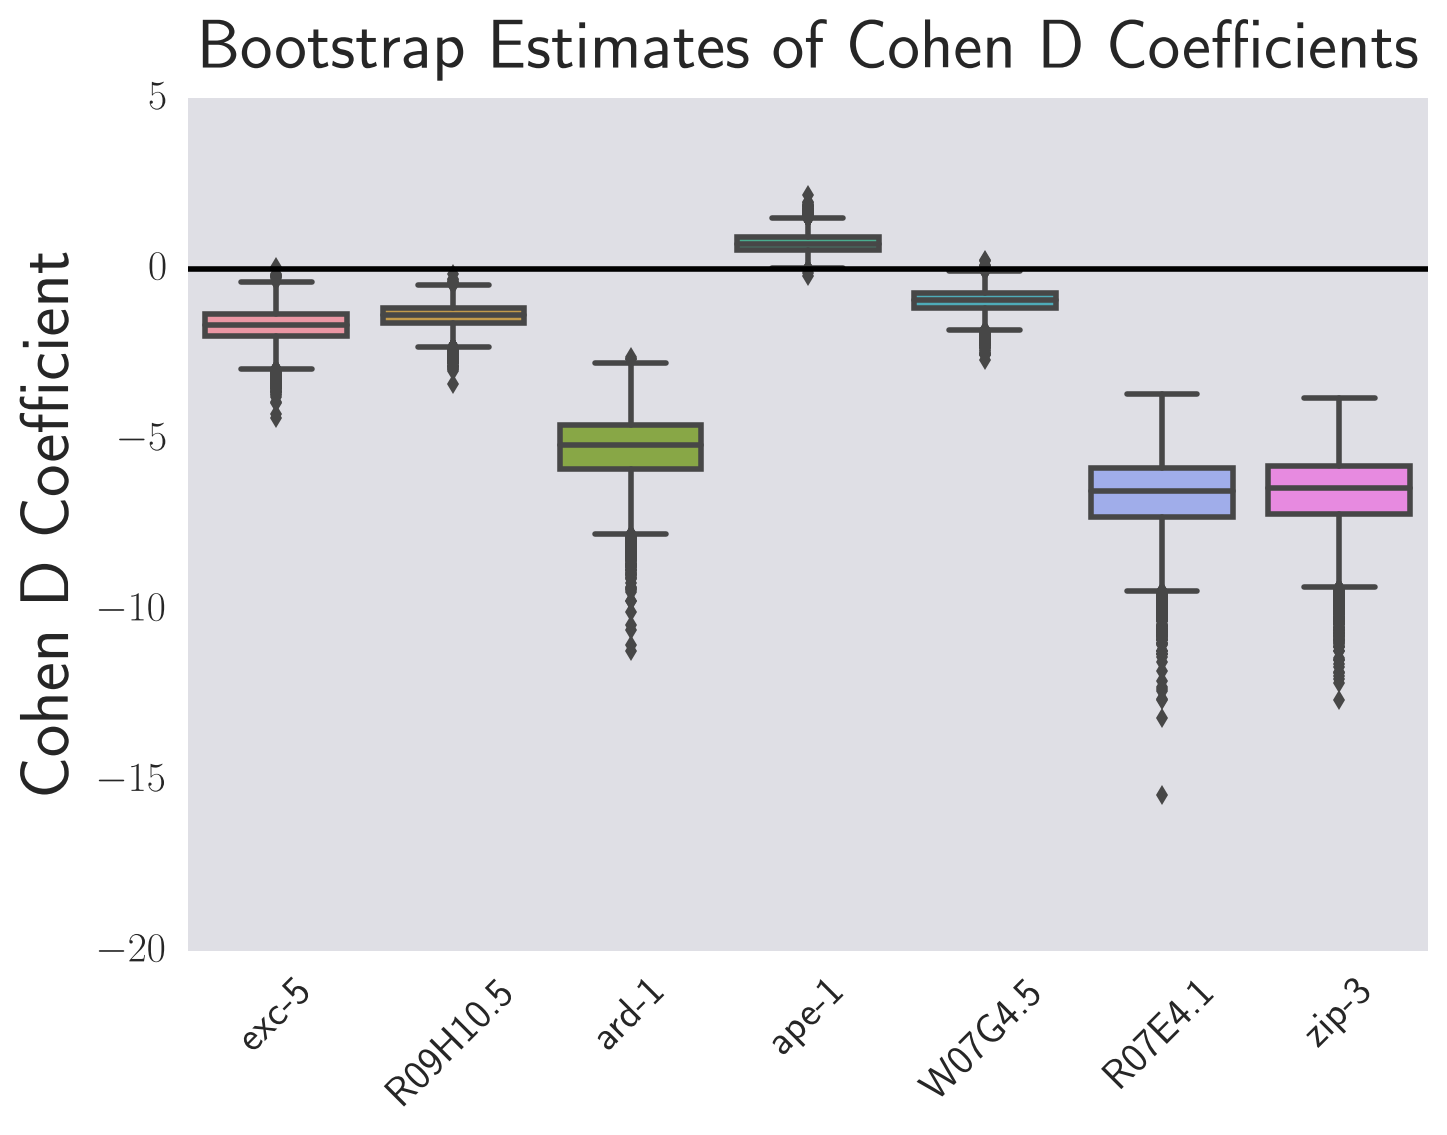

In [15]:
cohend = {'gene': genelist, 'Cohen D': cd}
# print(len(genelist), len(cd))
temp = pd.DataFrame(cohend)

sns.boxplot(x='gene', y='Cohen D', data=temp)
# plt.xticks(rotation=45, fontsize=xticksize)
# plt.yticks(fontsize=yticksize)
plt.axhline(0, color='k')
# plt.title('Bootstrap Estimates of Cohen D Coefficients')
# plt.ylabel('Cohen D Coefficient',fontsize=ylabelsize)
# plt.xlabel('',fontsize=xlabelsize)

xlab = ''
ylab = 'Cohen D Coefficient'
title = 'Bootstrap Estimates of Cohen D Coefficients'
fix_labels(xlab, ylab, title, xrotation=45, effects=True, ytitle=1.02)

# Lawn Leaving Screen

In [16]:
df_lol = pd.read_csv(input_path+'leaving_assay_and_oocyte_dropping.csv')
df_lol.strain = df_lol.strain.apply(str)
df_lol.strain = df_lol.strain.apply(str.lower)
df_lol = df_lol[df_lol.censor != 1].copy()
df_lol.strain = df_lol.strain.str.strip()
df_lol['gene'] = df_lol.strain.apply(translate)
# fraction off lawn
df_lol['fraction_off_lawn'] = df_lol.off_lawn_worms/(df_lol.off_lawn_worms + df_lol.lawn_worms)
# oocyte rate (oocytes per animal per day)
df_lol['oocyte_rate'] = (df_lol.oocyte_count/(df_lol.lawn_worms + df_lol.off_lawn_worms)*12)

## Fig 6b, Inset

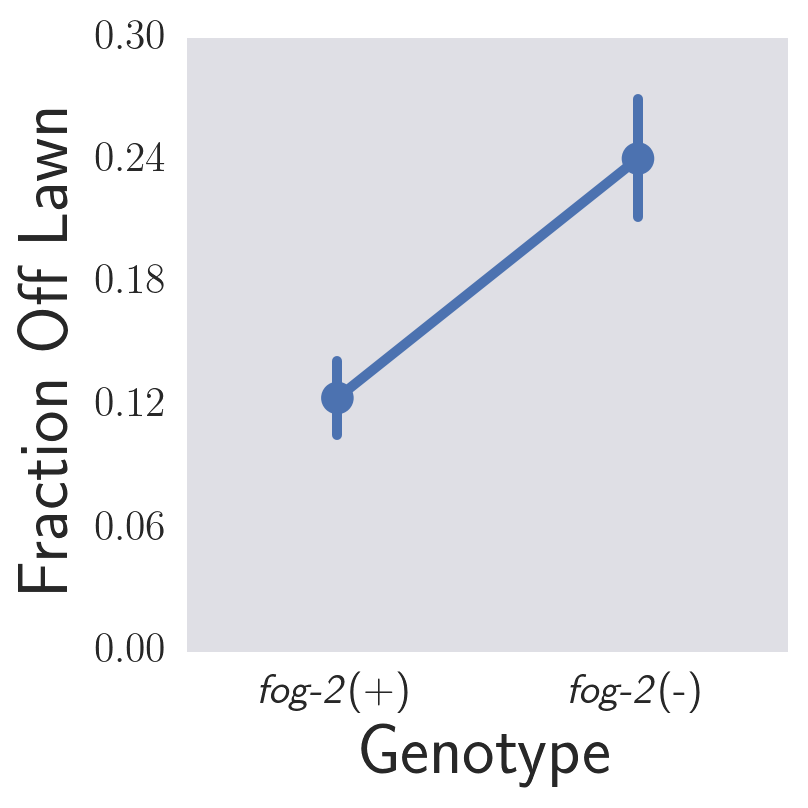

In [17]:
#if it doesn't compile, try it again...
temp = df_lol.sort_values('genotype', ascending=False)
g = sns.factorplot(x='genotype', y='fraction_off_lawn', data=temp)
g.set(xticklabels=[r'\emph{fog-2}(+)',r'\emph{fog-2}(-)'])

plt.yticks(np.linspace(0, 0.3, 6), fontsize=xticksize)
plt.xticks(fontsize=xticksize)
plt.ylabel('Fraction Off Lawn',fontsize=ylabelsize)
plt.xlabel('Genotype',fontsize=xlabelsize)
plt.savefig(graph_path + 'fraction_off_lawn_by_genotype.pdf', bbox_inches='tight')

In [18]:
def bootstrapped_chisquare(gene, df, y1, y2, reps=1000, control_name='gfp', **kwargs):
    """A function to calculate a bootstrapped chisquare"""
    def p_exp(y1, y2):
        """Returns the expected probability of y1"""
        return y1/(y1+y2)
    
    wt_y1 = df[df.gene == control_name][y1]
    wt_y2 = df[df.gene == control_name][y2]
    wt_p = p_exp(wt_y1, wt_y2)
    mu_p = wt_p.mean()
    
    mut_y1 = df[df.gene == gene][y1]
    mut_y2 = df[df.gene == gene][y2]
    mut_p = p_exp(mut_y1, mut_y2)
    
    
    def choose(x1, x2, inds_to_choose):
        """Resample x1, and x2."""
        selected = np.random.choice(inds_to_choose, len(x1), replace=True)
        return x1.values[selected], x2.values[selected]

    def resampled_chisquare(x1, x2, exp, n_trials=reps):
        """
        Get bootstrap samples of a chi-square statistic from repeated
        measurements `x`.
        """
        if len(x1) != len(x2):
            raise ValueError('lengths of x1 and x2 must match')
            
        # Indices that we use for resampling
        inds_to_choose = np.arange(len(x1), dtype=int)   
    
        # Samples to save
        samples = np.empty(n_trials)
                
        CHI = []
        for _ in range(n_trials):
            x1_, x2_ = choose(x1, x2, inds_to_choose)
            if len(x1_) != len(x2_):
                raise ValueError('x1_ and x2_ are not the same size!')
            chi = st.chisquare(x1_, (x1_+x2_)*exp)
            CHI += [chi[1]]
            
        return CHI
    
    
#     n_wt = len(wt_p)
#     n_mut = len(mut)
    
    # Initialize arrays
    chi_p_values = []

    # Do calcs!
    for i in range(reps):
        # Generate new data
        inds_to_choose = np.arange(len(wt_y1), dtype=int)
        new_wt1, new_wt2 = choose(wt_y1, wt_y2, inds_to_choose)
        exp = p_exp(new_wt1, new_wt2).mean()
        
        if len(mut_y1) == len(mut_y2):
            chi_p_values += resampled_chisquare(mut_y1, mut_y2, exp)
    return chi_p_values

In [19]:
def nice_plotting_with_chi_shade(df, x_name, y_name1, y_name2, y_plot, control='gfp',
                                 alpha=0.05, verbose=False, **kwargs):
    """A function to plot data, highlighting shaded columns if they pass stat. sig."""    
    hue = kwargs.pop('hue', 'date')
    ylim = kwargs.pop('ylim', [])
    bbox_to_anchor = kwargs.pop('bbox_to_anchor', (1.15, 1))
    rotation = kwargs.pop('rotation', 90)
    
    
    
    fig, ax = plt.subplots()
    g = sns.swarmplot(x_name, y_plot, hue=hue, data=df, size=10, ax=ax)
    plt.legend(bbox_to_anchor=bbox_to_anchor)
    plt.xticks(rotation=rotation)
    
    if len(ylim) > 0:
        plt.ylim(ylim)
    else:
        plt.ylim((0, 100))
    
    # shading and testing:
    control_total = df[(df[x_name] == control)][y_name1] + df[(df[x_name] == control)][y_name2]
    p_exp  = (df[(df[x_name] == control)][y_name1]/(control_total)).mean()
    
    sig_genes = []
    for i, gene in enumerate(df[x_name].unique()):
        # if gene is control, shade it in and continue
        # with the next loop
        if gene == control:
            ax.fill_between([i-0.5, i+0.5], 0.0, ax.get_ylim()[1], 
                            where=[1,1], color='#2ca25f', alpha=0.4, zorder=0)    
            continue
        
        # otherwise, test it and shade it in if pval < alpha
        x1 = df[df[x_name] == gene][y_name1]
        x2 = df[df[x_name] == gene][y_name2]
        
        if len(x1) > 2:
            pval = bootstrapped_chisquare(gene, df, y_name1, y_name2, reps=100, control_name=control)
            pval = np.mean(pval)
        
            pval_no_boot = st.chisquare(x1, (x1+x2)*p_exp)[1]
        
        else:
            pval = 1
        
        if pval > alpha:
            if pval_no_boot > alpha:
                continue
            print('{0} pval no boot would have falsely passed:\n {1:.2g} vs {2:.2g}'.format(gene,
                                                                                            pval,
                                                                                            pval_no_boot))
            continue
        
        if verbose:
            print('{0}, pvalue: {1:.2g}'.format(gene, pval))
        ax.fill_between([i-0.5, i+0.5], 0.0, ax.get_ylim()[1], 
                    where=[1,1], color='#404040', alpha=0.6, zorder=0)
        sig_genes += [gene]
    return sig_genes

## Fig 6a,b

dnj-8 pval no boot would have falsely passed:
 0.052 vs 0.015
ZK131.11, pvalue: 0.042
F42A10.7, pvalue: 0.0083
F09F7.5 pval no boot would have falsely passed:
 0.06 vs 0.034
col-113, pvalue: 0.048
F17E9.3, pvalue: 0.021
M01A8.1, pvalue: 0.02
C08F11.7, pvalue: 0.0058
pme-4 pval no boot would have falsely passed:
 0.051 vs 0.00073
exc-5, pvalue: 0.0003
F07C6.4 pval no boot would have falsely passed:
 0.13 vs 0.012
H24K24.4 , pvalue: 0.018
C14C10.2, pvalue: 0.048
F59H6.5, pvalue: 0.027
ard-1, pvalue: 0.048


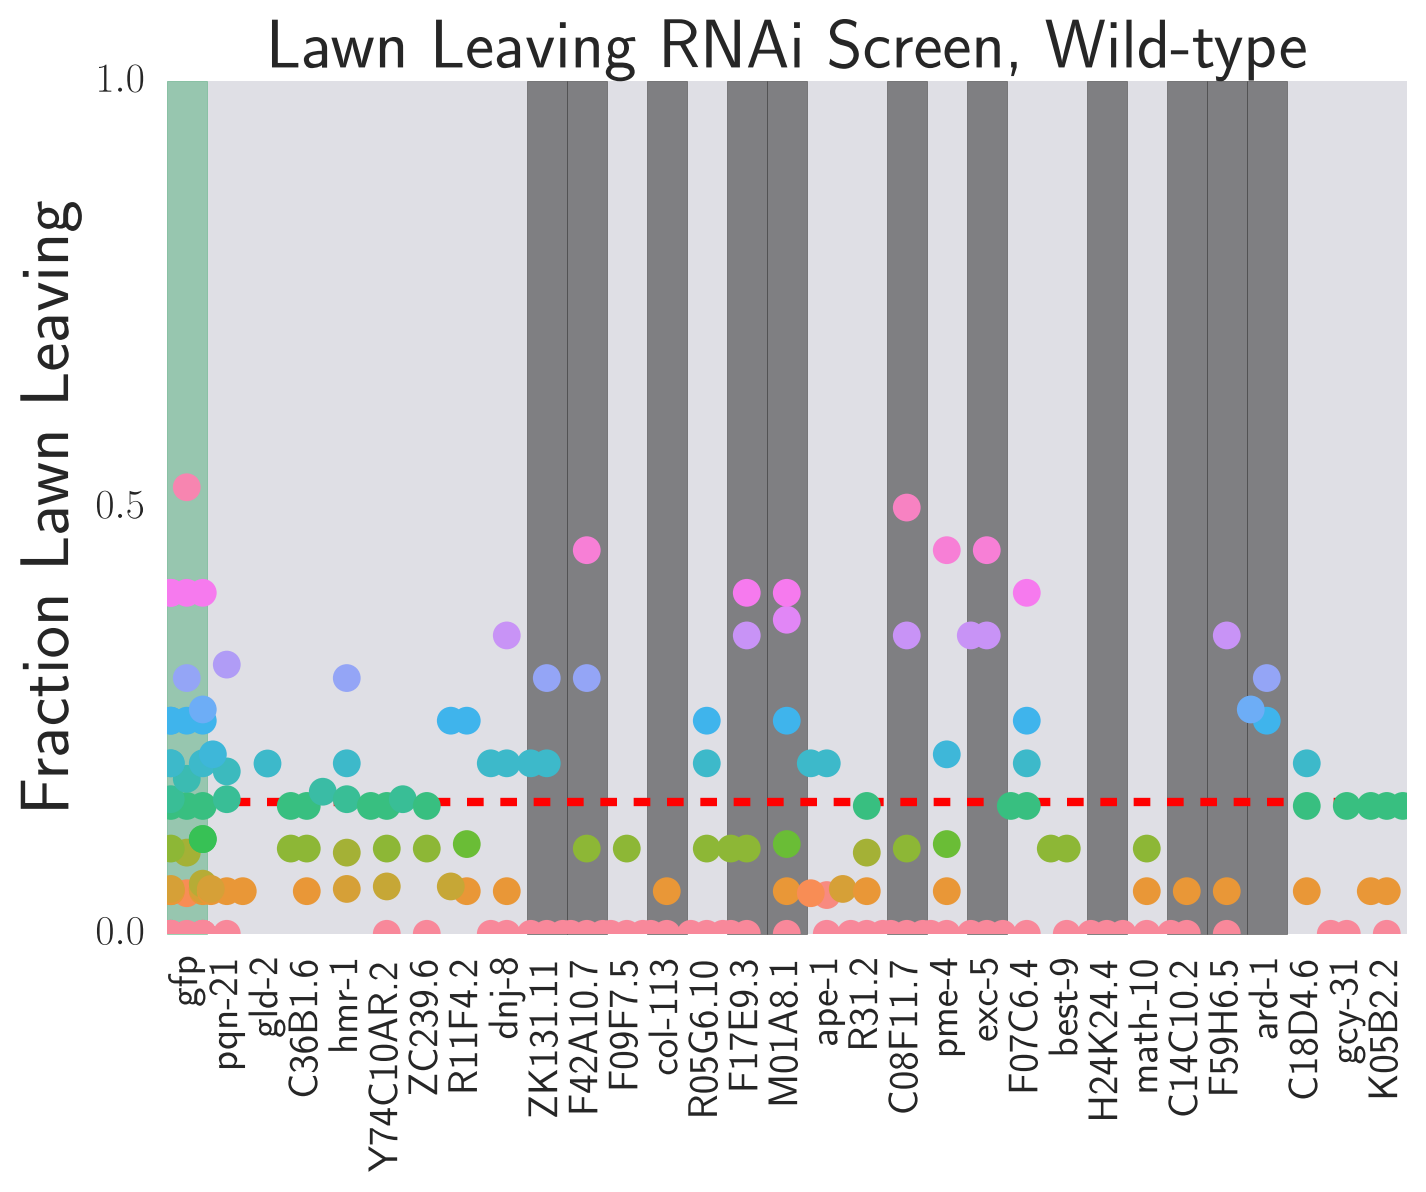

In [20]:
# sns.swarmplot(x='gene', y='fraction_off_lawn', data=df_lol[df_lol.genotype=='N2'], size=8)
sig_genes_lol = nice_plotting_with_chi_shade(df_lol[df_lol.genotype=='N2'], 'gene', 
                                             'off_lawn_worms', 'lawn_worms', 'fraction_off_lawn',
                                             hue='fraction_off_lawn', ylim=(0, 1), verbose=True)

plt.axhline(df_lol[df_lol.gene == 'gfp'].fraction_off_lawn.mean(), ls='--', lw=3, color='red')


ax = plt.gca()
ax.legend_.remove()

xlab = ''
ylab = 'Fraction Lawn Leaving'
title = 'Lawn Leaving RNAi Screen, Wild-type'

fix_labels(xlab, ylab, title, xrotation=90)
plt.yticks(np.linspace(0, 1, 3))
plt.savefig(graph_path+'lawn_leaving_screen_N2.pdf', bbox_inches='tight')

T10E9.3, pvalue: 0.041
nlp-12 pval no boot would have falsely passed:
 0.11 vs 0.0076
Y42G9A.2 pval no boot would have falsely passed:
 0.051 vs 0.00018
col-86, pvalue: 0.0019
unc-15, pvalue: 0.00011
nhx-6, pvalue: 0.0097
C23G10.6, pvalue: 0.0088
ZK892.6 pval no boot would have falsely passed:
 0.11 vs 0.031
nhr-74, pvalue: 0.0018
C17B7.5 pval no boot would have falsely passed:
 0.12 vs 0.047
W05B2.7 pval no boot would have falsely passed:
 0.074 vs 0.012
F57F4.2, pvalue: 0.011
R13A5.11, pvalue: 0.046


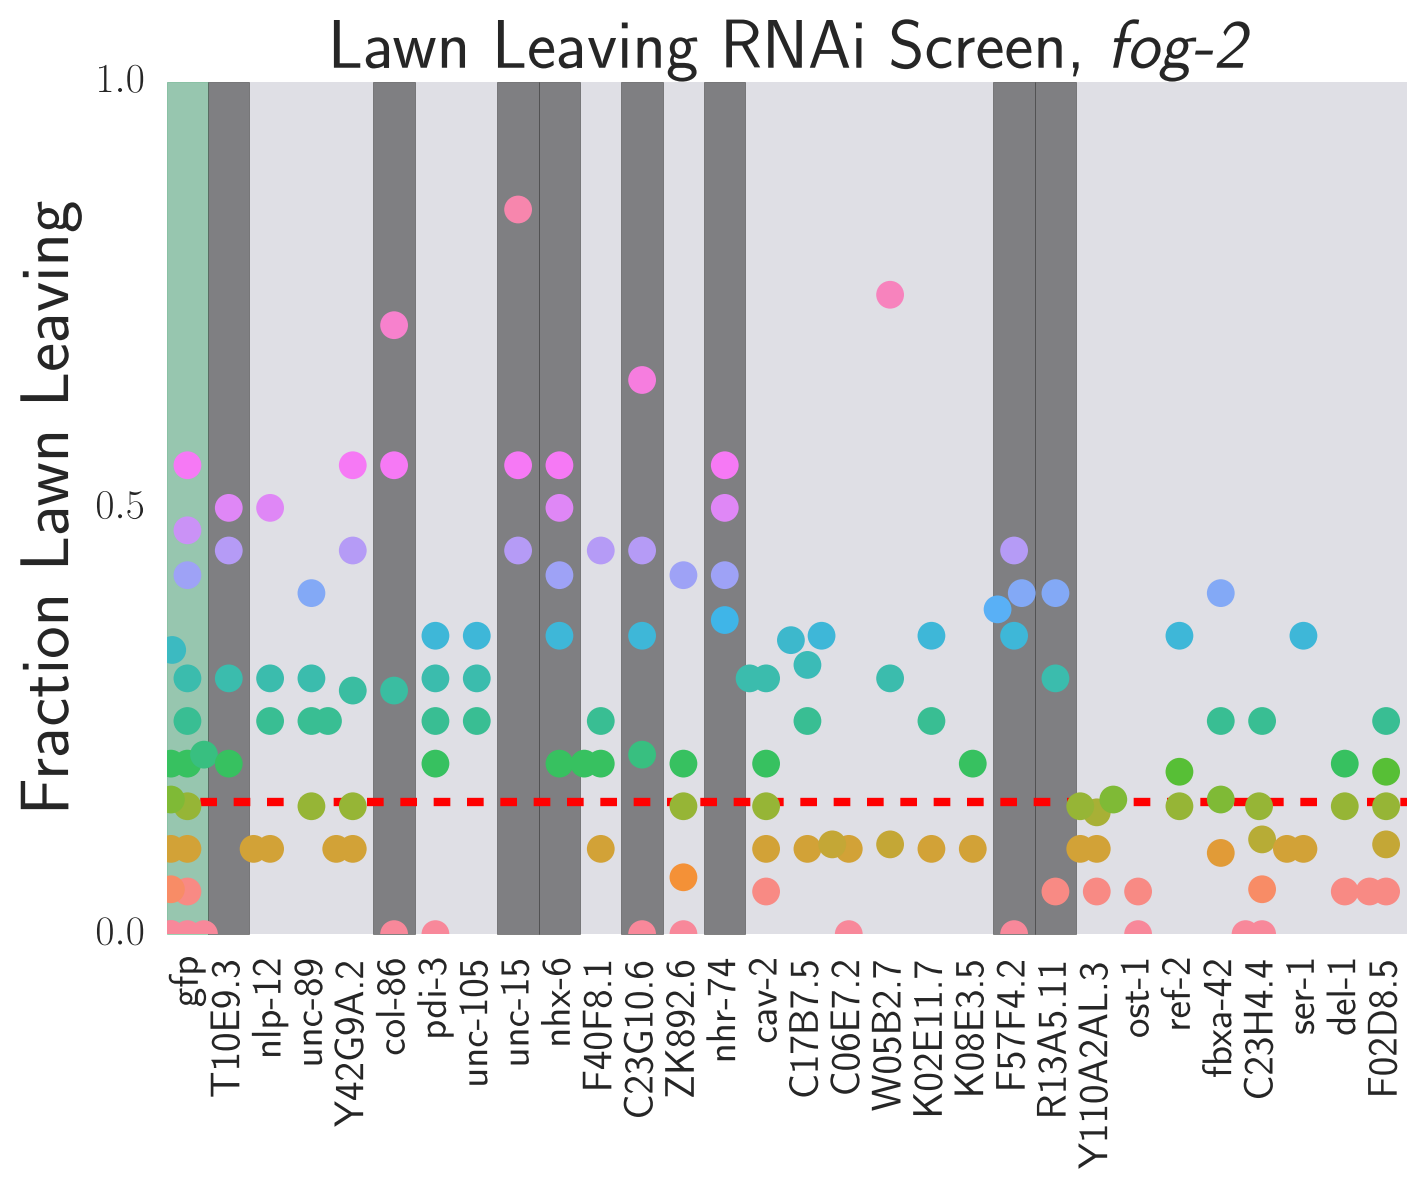

In [21]:
sig_genes_lol = nice_plotting_with_chi_shade(df_lol[df_lol.genotype=='JK'], 'gene', 
                                             'off_lawn_worms', 'lawn_worms', 'fraction_off_lawn',
                                             hue='fraction_off_lawn', ylim=(0, 1), verbose=True)

plt.axhline(df_lol[df_lol.gene == 'gfp'].fraction_off_lawn.mean(), ls='--', lw=3, color='red')

ax = plt.gca()
ax.legend_.remove()
xlab = ''
ylab = 'Fraction Lawn Leaving'
title = r'Lawn Leaving RNAi Screen, \emph{fog-2}'

fix_labels(xlab, ylab, title, xrotation=90)
plt.yticks(np.linspace(0, 1, 3))

plt.savefig(graph_path+'lawn_leaving_screen_JK.pdf', bbox_inches='tight')

# Ovulation Screen, Fig. 5

C23H4.4, pvalue: 0.0012


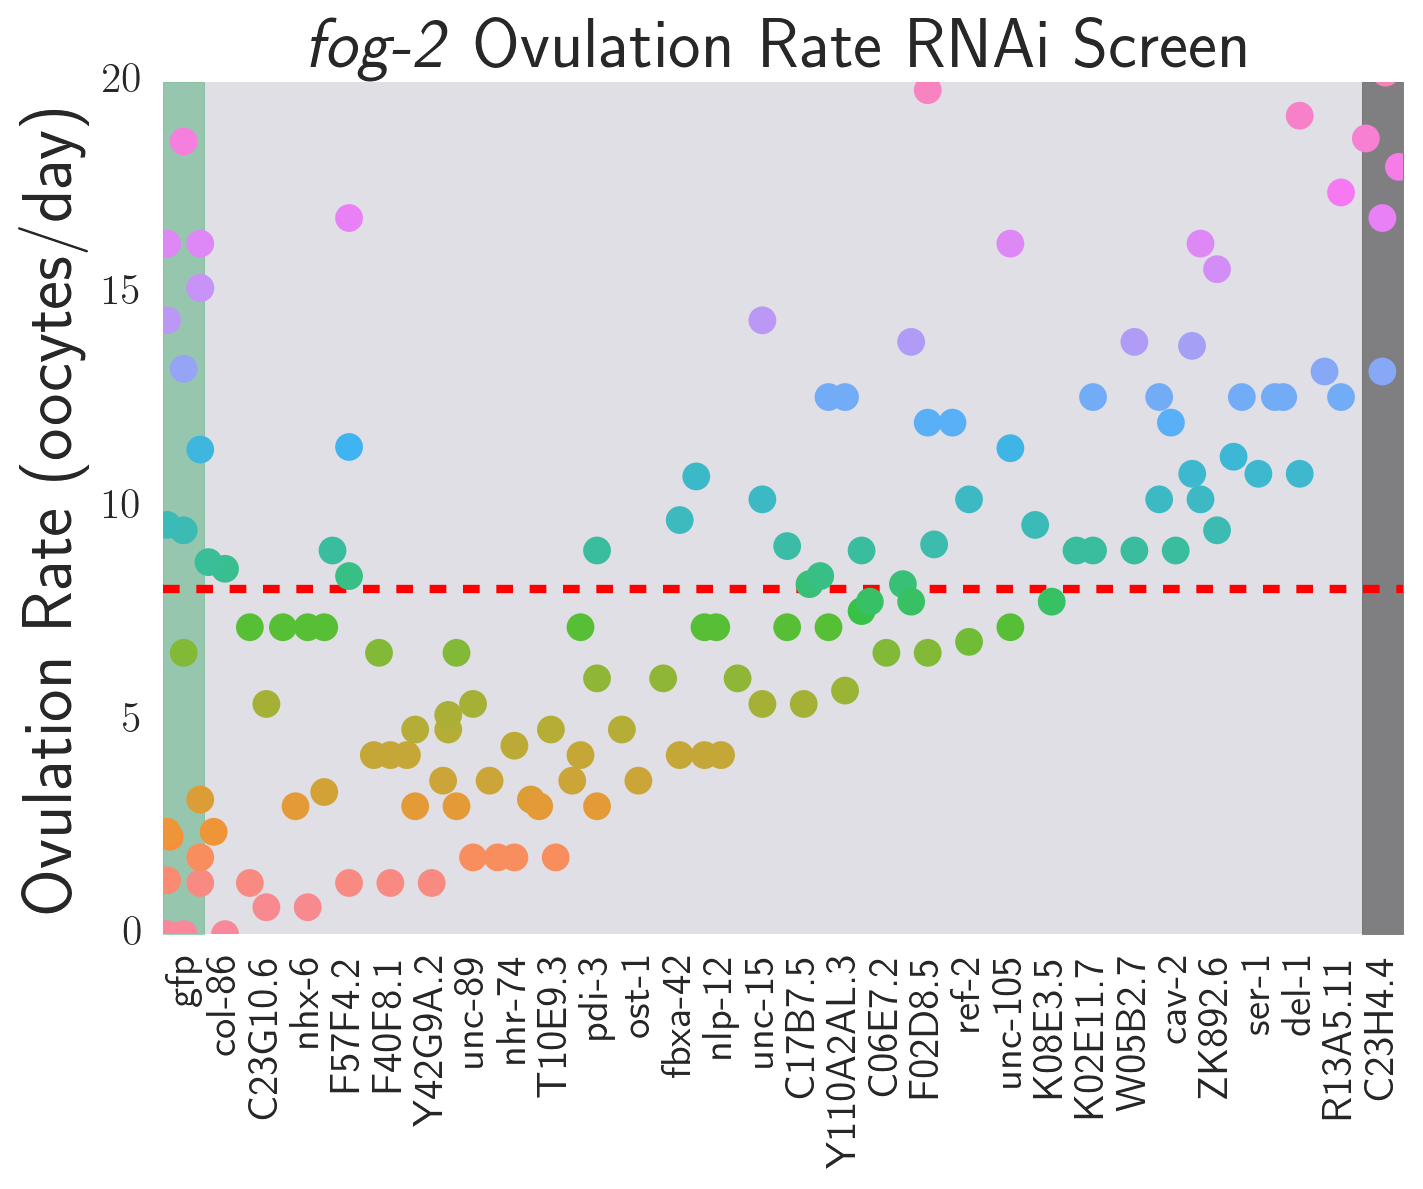

In [22]:
df_lol.sort_values('oocyte_rate', inplace=True)

sig_genes_od = nice_plotting_with_shade(df_lol[df_lol.genotype=='JK'], 'gene', 'oocyte_rate',
                         hue='oocyte_rate', ylim=(0, 20), verbose=True, test='rank')

plt.axhline(df_lol[df_lol.gene == 'gfp'].oocyte_rate.mean(), ls='--', lw=3, color='red')

ax = plt.gca()
ax.legend_.remove()
plt.xlabel('')
plt.ylabel('Ovulation Rate (oocytes/day)', fontsize=ylabelsize)
plt.xticks(fontsize=xticksize)
plt.yticks(fontsize=yticksize)
plt.title(r'\emph{fog-2} Ovulation Rate RNAi Screen', fontsize=titlesize)
plt.savefig(graph_path + 'oocyte_rate_assay.pdf', bbox_inches='tight')